Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import math

import cv2
import albumentations as Alb
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Compose Transformations

In [36]:
trueMean = [0.72891039, 0.56401498, 0.54739693]
std = [0.2081541, 0.19989766, 0.21353441]

trainTransformation = Alb.Compose([
    Alb.HorizontalFlip(p=0.4),
    Alb.VerticalFlip(p=0.4),
    Alb.Defocus(p=0.1),
    Alb.RandomGamma(p=0.3),
    # Alb.GaussNoise(p=0.05),
    Alb.Normalize(mean = trueMean, std = std, max_pixel_value=1.0),
    ToTensorV2()
    ])

testTransformation = Alb.Compose([
    Alb.Normalize(mean= trueMean, std = std, max_pixel_value=1.0),
    ToTensorV2()
])


Load In Dataset

In [37]:
#Done to be able to combine Albumentations and Pytorch ImageFolder
class CustomFolder(ImageFolder):
    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader(path)
        
        sample = cv2.imread(path, cv2.IMREAD_COLOR)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB) #Turns image from BGR to RGB for the correct formatting. Separate line for readability
        
        if self.transform is not None:
            sample = self.transform(image=sample)
            sample = sample["image"]
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

In [38]:
#Load data
trPath = r"C:\Users\jorge\Documents\Coding\MachineLearning\MelanomaDetection\Data\train"
tePath = r"C:\Users\jorge\Documents\Coding\MachineLearning\MelanomaDetection\Data\test"
train = CustomFolder(trPath, trainTransformation)
test = CustomFolder(tePath, testTransformation)

#Split data for testing

validDataset, testDataset = random_split(test, [0.5, 0.5])

batch_size = 16

#Create DataLoaders of each dataset split
trainLoader = DataLoader(train, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=True)

Neural Network Creation

In [39]:
classes = ('Benign', 'Malignant')

#Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda')
print(device)

cuda


Network Architecture and Blueprint

In [40]:
import torch.nn as nn
import torch.nn.functional as F

#From original Tensorflow Repository
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def Conv_3x3_BN(input, output, stride = 1):
    return nn.Sequential(
        nn.Conv2d(input, output, 3, stride, 1, bias=False), #Bias not needed with Batch Normalization
        nn.BatchNorm2d(output),
        nn.SiLU()
    )

def Conv_1x1_BN(input, output):
    return nn.Sequential(
        nn.Conv2d(input, output, 1, 1, 0, bias=False),
        nn.BatchNorm2d(output),
        nn.SiLU()
    )

#Squeeze and Excitation Layer
class SELayer(nn.Module):
    def __init__(self, input, output, reduction=4):
        super(SELayer, self).__init__()
        self.avgPool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(output, _make_divisible(input // reduction, 8)),
            nn.SiLU(),
            nn.Linear(_make_divisible(input // reduction, 8), output),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avgPool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


#Inspired by and from EfficientNetV2 and Mobile Inverted Bottleneck Convolution blocks
class MBConv(nn.Module):
    def __init__(self, input, output, stride, expandRatio, use_SE):
        super(MBConv, self).__init__()
        assert stride in [1,2]
        
        hiddenDim = round(input * expandRatio)

        self.identity = stride == 1 and input == output
        if use_SE:
            self.conv = nn.Sequential(
                #Pointwise Convolution -> Changes the number of channels without altering height or width of feature map
                nn.Conv2d(input, hiddenDim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hiddenDim),
                nn.SiLU(),

                #Depthwise Convolution -> 3x3 Convolution that applies a single fiter to each input channel
                nn.Conv2d(hiddenDim, hiddenDim, 3, stride, 1, groups=hiddenDim, bias=False),
                nn.BatchNorm2d(hiddenDim),
                nn.SiLU(),
                SELayer(input, hiddenDim), #Squeeze and Excitation Layer

                #Pointwise Linear Convolution 
                nn.Conv2d(hiddenDim, output, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output),
            )
        else:
            self.conv = nn.Sequential(
                #Fused
                nn.Conv2d(input, hiddenDim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hiddenDim),
                nn.SiLU(),
                
                #Pointwise Linear Convolution
                nn.Conv2d(hiddenDim, output, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output),
            )
    
    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class ConvolutionalNN(nn.Module):
    def __init__(self, cfgs, width_mult = 1.):
        super(ConvolutionalNN, self).__init__()

        #Essentially the network blueprint

        self.cfgs = cfgs
        
        #First Layer
        inputChannel = _make_divisible(24 * width_mult, 8)
        layers = [Conv_3x3_BN(3, inputChannel, 2)]

        # building inverted residual blocks

        block = MBConv
        
        for t, c, n, s, use_se in self.cfgs:
            outputChannel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(inputChannel, outputChannel, s if i == 0 else 1, t, use_se))
                inputChannel = outputChannel

        self.features = nn.Sequential(*layers)

        outputChannel = 1024
        self.conv = Conv_1x1_BN(inputChannel, outputChannel)
        self.avgPool = nn.AdaptiveMaxPool2d((1,1))
        self.classifier = nn.Linear(outputChannel, 2)

        self._initialize_weights()


    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgPool(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)


        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()

In [41]:
epochLength = len(trainLoader)
print(epochLength)

743


Training and Testing

In [42]:
criterion = nn.CrossEntropyLoss()

def Test(model, loader):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0

        n_class_correct = [0 for i in range(2)]
        n_class_samples = [0 for i in range(2)]

        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
        

    accuracy = 100 * n_correct / n_samples
    
    model.train(True)
    return accuracy

In [43]:
def PlotStatistics(trainingLoss, validationLoss, totalAcc, lrs, valImprovement):
    plt.figure(figsize = (15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(trainingLoss, label = 'Training Loss')
    plt.plot(validationLoss, label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(totalAcc, label = 'Total Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(lrs, label="Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(valImprovement, label = "Change in Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Improvement")
    plt.legend()

    plt.show()

In [44]:
#Plateau
def Sequence(model, optimizer, patience = 7):
    scaler = GradScaler()

    scheduler = ReduceLROnPlateau(optimizer, "min", 0.9, 2, 1e-2)

    minDelta = 0.005
    currentPatience = 0
    bestLoss = float('inf')

    trainingLoss = []
    validationLoss = []
    valImprovement = []
    lrs = []

    totalAcc = []

    #Training Loop
    for epoch in range(28):
        model.train()
        runLoss = 0.0
        for i, (images, labels) in enumerate(trainLoader):
            #GPU support
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            #Forward pass:

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            #Scale Gradients then Backward and Optimize

            runLoss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            trainLoss = runLoss / (i+1)
            update = f"Step [{i+1}/{epochLength}] Loss [{trainLoss:.4f}]"
            print("\r"  + update, end = "")

            if (i + 1) % epochLength == 0:
                trainLoss = runLoss / len(trainLoader)
                trainingLoss.append(trainLoss)
                update = f'Epoch [{epoch+1}] Loss [{trainLoss:.4f}]'
                print("\r" + update, end = " ----> ")

        #Validation
        with torch.no_grad():
            valLoss = 0.0
            for i, (images, labels) in enumerate(validLoader):
                #GPU support
                images = images.to(device)
                labels = labels.to(device)
                #Forward pass:
                outputs = model(images)
                loss = criterion(outputs, labels)

                valLoss += loss.item()
                #NO backward and optimize // Validation Loss is meant to serve as a metric
            avgLoss = valLoss / len(validLoader)
            validationLoss.append(avgLoss)
        
        #Keeping track of improvement
        if epoch != 0:
            valLossImprovement = avgLoss - validationLoss[epoch-1]
            valImprovement.append(valLossImprovement)

        #Testing Phase
        accuracy = Test(model, testLoader)

        totalAcc.append(accuracy)
        
        # Early Stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                print(f"EARLY STOPPING TRIGGERED! FINAL VALIDATION LOSS [{avgLoss:.4f}]")
                print(f"FINAL RESULTS OVERALL ACCURACY [{accuracy:.2f}]")
                break
        print(f"Validation Loss [{avgLoss:.4f}], Patience [{currentPatience}/{patience}]")
        print(f"Accuracy [{accuracy:.2f}]")

        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step(avgLoss) #for ReduceLROnPlateau
    
    PlotStatistics(trainingLoss, validationLoss, totalAcc, lrs, valImprovement)

Epoch [1] Loss [0.3975] ----> Validation Loss [0.3621], Patience [0/7]
Accuracy [81.70]
Epoch [2] Loss [0.3313] ----> Validation Loss [0.2606], Patience [0/7]
Accuracy [88.70]
Epoch [3] Loss [0.3058] ----> Validation Loss [0.2941], Patience [1/7]
Accuracy [87.60]
Epoch [4] Loss [0.2901] ----> Validation Loss [0.2668], Patience [2/7]
Accuracy [89.70]
Epoch [5] Loss [0.2837] ----> Validation Loss [0.2978], Patience [3/7]
Accuracy [88.30]
Epoch [6] Loss [0.2690] ----> Validation Loss [0.2461], Patience [0/7]
Accuracy [88.50]
Epoch [7] Loss [0.2579] ----> Validation Loss [0.2795], Patience [1/7]
Accuracy [85.30]
Epoch [8] Loss [0.2501] ----> Validation Loss [0.2995], Patience [2/7]
Accuracy [86.20]
Epoch [9] Loss [0.2451] ----> Validation Loss [0.2302], Patience [0/7]
Accuracy [90.80]
Epoch [10] Loss [0.2329] ----> Validation Loss [0.2347], Patience [1/7]
Accuracy [90.80]
Epoch [11] Loss [0.2361] ----> Validation Loss [0.2107], Patience [0/7]
Accuracy [93.90]
Epoch [12] Loss [0.2210] ---->

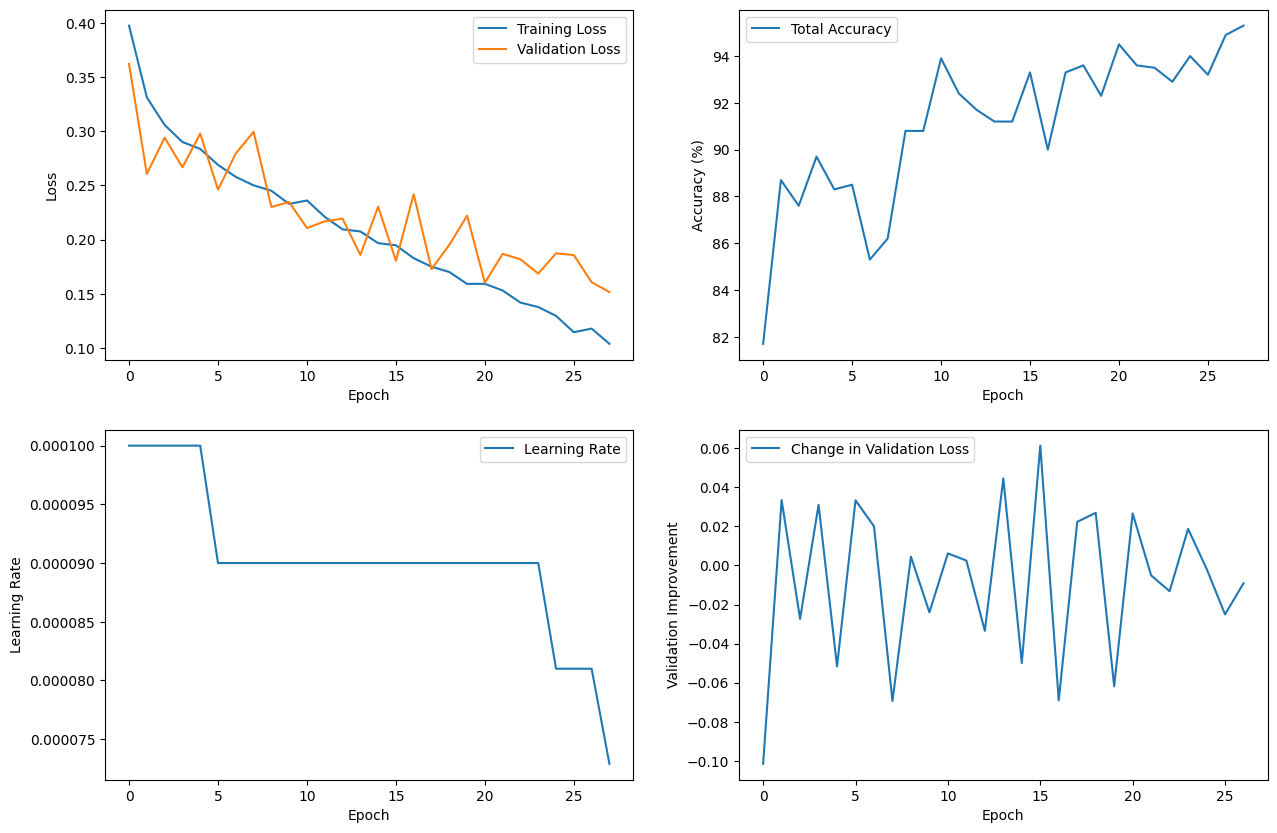

In [45]:
# 95.3% PEAK - EPOCH 28
cfgs = [
            #t, c, n, s, SE
            [1, 48, 1, 1, 0],   #t = Expansion Factor
            [2, 48, 1, 2, 0],   #c = Output Channels
            [2, 96, 2, 2, 0],   #n = Number of Blocks 
            [4, 96, 2, 2, 1],  #s = Stride
            [6, 128, 3, 1, 1],  #SE = Whether to use Squeeze and Excitation Layer or not
            [6, 160, 6, 2, 1]
        ]
  
model = ConvolutionalNN(cfgs=cfgs).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 0.0001, weight_decay = 0.05)

Sequence(model, optimizer)

In [46]:
# torch.save(model.state_dict(), r"C:\Users\jorge\Documents\Coding\MachineLearning\MelanomaDetection\ModelCheckpoints\PeakModel.pt")

Evaluation

In [47]:
# cfgs = [
#             #t, c, n, s, SE
#             [1, 48, 1, 1, 0],   #t = Expansion Factor
#             [2, 48, 1, 2, 0],   #c = Output Channels
#             [2, 96, 2, 2, 0],   #n = Number of Blocks 
#             [4, 96, 2, 2, 1],  #s = Stride
#             [6, 128, 3, 1, 1],  #SE = Whether to use Squeeze and Excitation Layer or not
#             [6, 160, 6, 2, 1]
#         ]

# model = ConvolutionalNN(cfgs)
# model.load_state_dict(torch.load(r"C:\Users\jorge\Documents\Coding\MachineLearning\MelanomaDetection\ModelCheckpoints\PeakModel.pt"))
# model.to(device)
# model.eval()

In [61]:
model.eval()
print(Test(model, trainLoader))
print(Test(model, validLoader))
print(Test(model, testLoader))

97.23882481690379
94.9
95.3


In [62]:
testLabels = []
predictedLabels = []

with torch.no_grad():
    for images, labels in testLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        testLabels.extend(list(labels.to("cpu")))
        predictedLabels.extend(predicted.to("cpu").tolist())

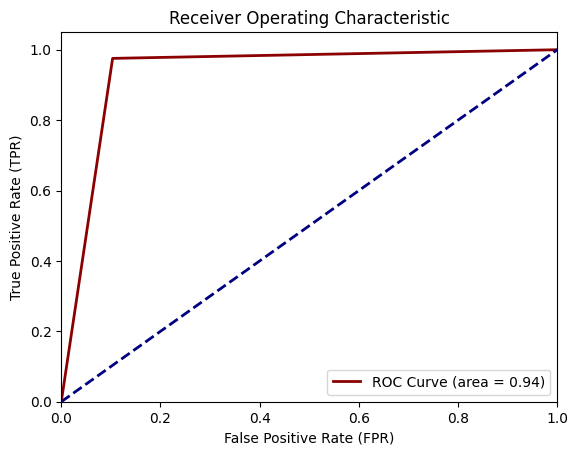

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(testLabels, predictedLabels)
roc_auc = roc_auc_score(testLabels, predictedLabels)

plt.figure()
plt.plot(fpr, tpr, color="darkred", lw=2, label=f"ROC Curve (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], color = "navy", lw=2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

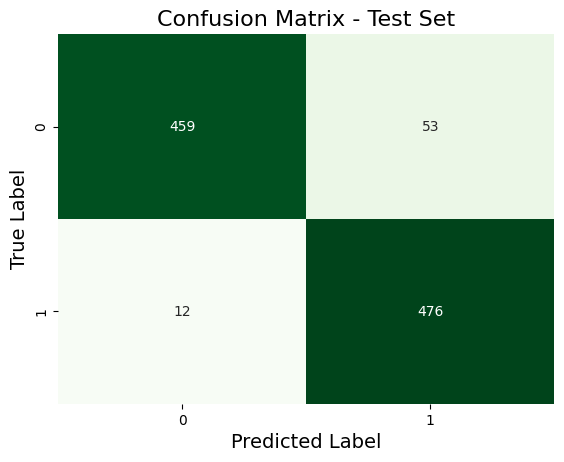

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting confusion matrix for test data
matrix = confusion_matrix(testLabels, predictedLabels)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = [0,1], yticklabels = [0,1], cbar = False)
plt.title('Confusion Matrix - Test Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()